# Figure containing all fitted densities for the first stock's returns


Number of values outside the range [-15,15] : 14


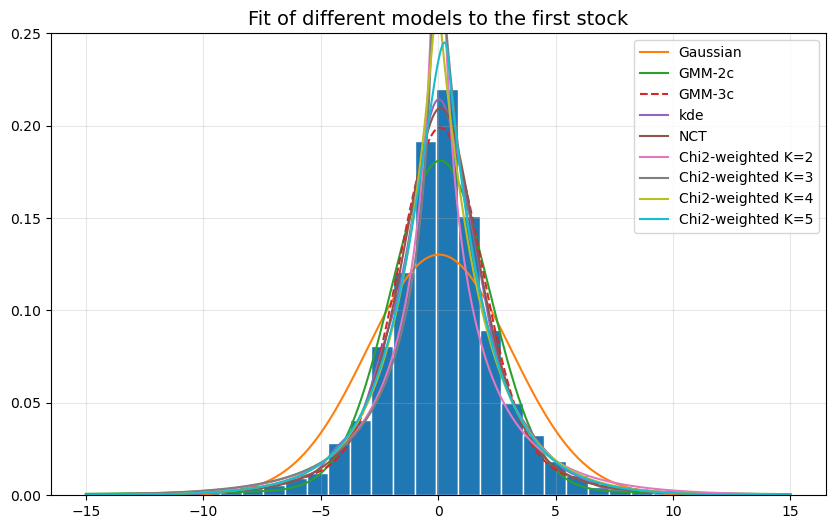

In [12]:
# Loading the data
import numpy as np
import pandas as pd
from scipy.stats import norm, Mixture, Normal, gaussian_kde, nct
import matplotlib.pyplot as plt

# array of percentage log returns
stock = np.load('data/plr_stocks.npy')[0]

# count how many values outside of range [-15,15]
mask_count = (stock >= 15) | (stock <=-15)
print('Number of values outside the range [-15,15] :', np.sum(mask_count))
mask = (stock >= -15) & (stock <= 15)
stock = stock[mask]

gaussian_fit_stock = pd.read_csv('results/gaussian.csv')
mu1 = gaussian_fit_stock.iloc[0]['mu']
sigma1 = gaussian_fit_stock.iloc[0]['sigma']

x = np.linspace(-15, 15, 2000)
plt.figure(figsize=(10, 6))
plt.hist(stock, bins = 30, edgecolor = 'white', density=True)
plt.plot(x, norm.pdf(x, loc = mu1, scale = sigma1), label = 'Gaussian')

# gaussian mixture fit 2 components
gmm2c_fit_stock = pd.read_csv('results/gmm2c_init150_fitted_params.csv')
pi1gmm2c = gmm2c_fit_stock.iloc[0]['pi1']
pi2gmm2c = gmm2c_fit_stock.iloc[0]['pi2']
mu1gmm2c = gmm2c_fit_stock.iloc[0]['mu1']
mu2gmm2c = gmm2c_fit_stock.iloc[0]['mu2']
sigma1gmm2c = gmm2c_fit_stock.iloc[0]['sigma1']
sigma2gmm2c = gmm2c_fit_stock.iloc[0]['sigma2']

X1_2c = Normal(mu=mu1gmm2c, sigma=sigma1gmm2c)
X2_2c = Normal(mu=mu2gmm2c, sigma=sigma2gmm2c)

gmm_dist_2c = Mixture(components=[X1_2c, X2_2c], weights=[pi1gmm2c, pi2gmm2c])
plt.plot(x, gmm_dist_2c.pdf(x), label = 'GMM-2c')

# gaussian mixture fit 3 components (degenerate distribution because of sigma < 0.001 for 3rd compnonent)
gmm3c_fit_stock = pd.read_csv('results/gmm3c_init5_fitted_params.csv')
pi1gmm3c = gmm3c_fit_stock.iloc[0]['pi1']
pi2gmm3c = gmm3c_fit_stock.iloc[0]['pi2']
pi3gmm3c = gmm3c_fit_stock.iloc[0]['pi3']
mu1gmm3c = gmm3c_fit_stock.iloc[0]['mu1']
mu2gmm3c = gmm3c_fit_stock.iloc[0]['mu2']
mu3gmm3c = gmm3c_fit_stock.iloc[0]['mu3']
sigma1gmm3c = gmm3c_fit_stock.iloc[0]['sigma1']
sigma2gmm3c = gmm3c_fit_stock.iloc[0]['sigma2']
sigma3gmm3c = gmm3c_fit_stock.iloc[0]['sigma3']

X1_3c = Normal(mu=mu1gmm3c, sigma=sigma1gmm3c)
X2_3c = Normal(mu=mu2gmm3c, sigma=sigma2gmm3c)
X3_3c = Normal(mu=mu3gmm3c, sigma=sigma3gmm3c)

gmm_dist_3c = Mixture(components=[X1_3c, X2_3c, X3_3c], weights=[pi1gmm3c, pi2gmm3c, pi3gmm3c])
plt.plot(x, gmm_dist_3c.pdf(x), label = 'GMM-3c', linestyle = '--')

# Gaussian KDE
kde = gaussian_kde(stock)
plt.plot(x, kde.pdf(x), label = 'kde')

# Non central t
nct_fit = pd.read_csv('results/nct_fit.csv')
df_nct = nct_fit.iloc[0]['df']
nc_nct = nct_fit.iloc[0]['nc']
loc_nct = nct_fit.iloc[0]['mu']
sigma_nct = nct_fit.iloc[0]['sigma']

plt.plot(x, nct.pdf(x, df = df_nct, nc = nc_nct, loc = loc_nct, scale = sigma_nct), label = 'NCT')

plt.title('Fit of different models to the first stock', fontsize = 14)
#plt.legend()
plt.grid(True, alpha = 0.3)
#plt.show()


# weighted chi^2 sums
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ---- (1) load fitted chi2-weighted params (K=2..5) ----
chi2_files = {
    2: "results/chi2_weighted_K2.csv",
    3: "results/chi2_weighted_K3.csv",
    4: "results/chi2_weighted_K4.csv",
    5: "results/chi2_weighted_K5.csv",
}

import re
import numpy as np

def _extract_loc_and_weights(df, stock_idx, K):
    # choose row
    if "stock" in df.columns:
        row = df.loc[df["stock"] == stock_idx + 1].iloc[0]
    else:
        row = df.iloc[stock_idx]

    # location parameter
    mu = 0.0
    for loc_col in ["mu", "loc", "location", "delta", "m"]:
        if loc_col in df.columns:
            mu = float(row[loc_col])
            break

    # collect weight-like columns (supports w_1, w1, weight_2, omega_3, lambda_4, ...)
    cols = []
    for c in df.columns:
        s = str(c)
        m = re.match(r"^(w|weight|omega|lambda)_?(\d+)$", s)
        if m:
            cols.append((int(m.group(2)), s))

    cols = [name for _, name in sorted(cols, key=lambda t: t[0])]

    if len(cols) < K:
        raise ValueError(f"Could not find {K} weight columns in {df.columns.tolist()}")

    w = np.array([float(row[c]) for c in cols[:K]], dtype=float)
    return mu, w


# ---- (2) FFT-based pdf for mu + sum_j w_j * ChiSquare_1 ----
def _chi2_weighted_pdf_fft_grid(x_min, x_max, N, weights, mu=0.0):
    dx = (x_max - x_min) / N
    t  = 2 * np.pi * np.fft.fftfreq(N, d=dx)   # includes +/- frequencies
    phi = np.exp(1j * t * mu)
    for w in weights:
        phi *= (1 - 2j * t * w) ** (-0.5)      # cf of w*ChiSquare_1

    dt = 2 * np.pi / (N * dx)
    f = (dt / (2 * np.pi)) * np.fft.fft(phi * np.exp(-1j * t * x_min))
    x_grid = x_min + np.arange(N) * dx
    f = np.real(f)
    f = np.clip(f, 0.0, None)                  # kill small FFT ringing negatives
    return x_grid, f

def chi2_weighted_pdf_on_x(x_plot, weights, mu=0.0, N=2**14, margin=5.0):
    x_min = float(np.min(x_plot) - margin)
    x_max = float(np.max(x_plot) + margin)
    xg, fg = _chi2_weighted_pdf_fft_grid(x_min, x_max, N, weights, mu)
    return np.interp(x_plot, xg, fg, left=0.0, right=0.0)

# ---- (3) plot all chi2 K=2..5 for the current stock ----
stock_idx = 0  # stock 1 -> 0; stock 2 -> 1; etc.

# assumes you already have: x = np.linspace(-15, 15, 2000)
for K, fpath in chi2_files.items():
    dfK = pd.read_csv(fpath)
    muK, wK = _extract_loc_and_weights(dfK, stock_idx, K)
    pdfK = chi2_weighted_pdf_on_x(x, wK, mu=muK, N=2**14, margin=5.0)
    plt.plot(x, pdfK, label=f"Chi2-weighted K={K}")

# (keep your existing legend/show)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

